In [323]:
import numpy as np
import random
from matplotlib import pyplot as plt

In [324]:
class RecylingRobot():
    def __init__(self,alpha,beta):
        self.alpha = alpha
        self.beta = beta
        
        self.statesplus = ['high','low']    
        self.states =  ['high','low']    
        
        # initial state
        self.state = 'high'
                
        self.actions = {'search':self.search,'wait':self.wait,'recharge':self.recharge}
        self.action_labels = ['search','wait','recharge']
        
        
        self.state_action_list = [('high','search'), ('high','wait'),
                                  ('low','search'),('low','wait'),('low','recharge')]
        
        # Policy 
        self.pi = None

        
        # Setting the Dynamics
#         self.pr = {}
#         self.pr[('high','search','high',self.r_search)]= self.alpha
#         self.pr[('high','search','low',self.r_search)]= 1-self.alpha
#         self.pr[('high','wait','high',self.r_wait)]= 1
#         self.pr[('low','search','low',self.r_search)]= self.beta
#         self.pr[('low','search','high',-3)]= 1-self.beta
#         self.pr[('low','wait','low',self.r_wait)]= 1
#         self.pr[('low','recharge','high',0)]= 1
        
        
    def search(self,state):
        if state=='high':
            p = random.random()
            if p<self.alpha:
                next_state, reward = 'high',random.choice([3,4,5,6])
            else:
                next_state, reward = 'low',random.choice([3,4,5,6])
        
        if state=='low':
            p = random.random()
            if p<self.beta:
                next_state, reward = 'low',random.choice([3,4,5,6])
            else:
                next_state, reward = 'high',-3
        
        return next_state, reward
    
    def wait(self,state):
        next_state = state
        reward = random.choice([0,1,2])
        
        return next_state, reward
    
    def recharge(self,state):
        assert state=='low',ValueError("Invalid Action")
        next_state , reward = 'high' , 0
        return next_state, reward
    
    
    
            
    def generate_random_experiment(self,l):
        assert self.pi , AttributeError('GridWorld has no policy yet, use set_policy method first')
        self.state = random.choice(['high','low'])
        state_action_list =f'{self.state }'
        
        episode = []
        for i in range(l):
            action = random.choices(list(self.pi[self.state].keys()),
                                    weights=list(self.pi[self.state].values()))[0] 
            new_state , new_reward = self.actions[action](self.state)
            state_action_list += f'-> {action} -> {new_reward} -> {new_state} '
            episode.append((self.state,action,new_reward,new_state))
            self.state = new_state
        return episode
    
    
    def generate_random_experiment_start_exploring(self,l):
        assert self.pi , AttributeError('GridWorld has no policy yet, use set_policy method first')
        state,action = random.choice(self.state_action_list)
        
        new_state , new_reward = self.actions[action](state)
        
        episode = [(state,action,new_reward,new_state)]
        self.state = new_state
        for i in range(l-1):
            action = random.choices(list(self.pi[self.state].keys()),
                                    weights=list(self.pi[self.state].values()))[0] 
            new_state , new_reward = self.actions[action](self.state)
            episode.append((self.state,action,new_reward,new_state))
            self.state = new_state
        return episode
    
    def show_episode(self,episode):
        state_action_list =f'{episode[0][0] }'
        
        for transition in episode:
            state_action_list += f'-> {transition[1]} -> {transition[2]} -> {transition[3]} '

        return state_action_list
        
            
    
    def mc_first_action(self,episode):
        G = 0
        for tr in episode[::-1]: 
            G = self.gamma*G + tr[2]
        return episode[0][0],episode[0][1],G
    
    
    def mc_first_state(self,episode):
        
        state_G = {}
        
        G = 0
        for tr in episode[::-1]: 
            G = self.gamma*G + tr[2]
            state_G[tr[0]] = G # if we see a state, visit_flag would be True
        
        return state_G
    
    
    def first_visit_state(self,n_episode):
        
        state_value = {state:[] for state in self.states }
        state_value_average = {state:[] for state in self.states }
        for i in range(n_episode):    
            episode = self.generate_random_experiment(4)
            v_s = self.mc_first_state(episode)
            
            for state,G in v_s.items():
                state_value[state].append(G)
            
            for state in self.states:
                if len(state_value[state])>0:
                    state_value_average[state].append(sum(state_value[state])/(len(state_value[state])))
                else:
                    state_value_average[state].append(0)
                
        return state_value_average
    
    
    
    def td_state(self,steps,alpha):
        state_value = {state:[0] for state in self.states }
        state_value_update_time = {state:[0] for state in self.states }
        
        episode = self.generate_random_experiment(steps)
        
        G = 0
        for t,transition in enumerate(episode,1):
            state,action,reward,new_state = transition
            state_value[state].append( state_value[state][-1]+ alpha*(reward + self.gamma*state_value[new_state][-1]- state_value[state][-1]))
            state_value_update_time[state].append(t)
        
        return state_value,state_value_update_time
    
    
    def td_state_action(self,steps):
        pass
    
    def epsilon_greedy(self, state, epsilon):
        if random.uniform(0,1) < epsilon:
            possible_actions = [a for s,a in self.state_action_list if s==state]
            return random.sample(possible_actions,1)[0]
        else:
            sa = {sa[1]:v for sa,v in self.Q.items() if sa[0]==state}
            return max(sa.items(), key = lambda x: x[1])[0]
    
    
    def first_visit_action(self,n_episode):
        
        state_action_value = {(state,action):[] for state,action in self.state_action_list}
        state_action_average = {(state,action):[] for state,action in self.state_action_list}
        for i in range(n_episode):    
            episode = self.generate_random_experiment_start_exploring(4)
            state,action,value = self.mc_first_action(episode)
            
            state_action_value[(state,action)].append(value)
            
            for state,action in self.state_action_list:
                if len(state_action_value[(state,action)])>0:
                    state_action_average[(state,action)].append(sum(state_action_value[(state,action)])/(len(state_action_value[(state,action)])))
                else:
                    state_action_average[(state,action)].append(0)
                

        return state_action_average
    
    
    
    def sarsa(self,n_steps,alpha, epsilon):
        
        ################# Initialize Q table #############
        
        self.Q = {}
        for state,action in self.state_action_list:
            self.Q[(state,action)] = 0
                
                
        self.Q_history = {}
        for state,action in self.state_action_list:
            self.Q_history[(state,action)] = [0]
        
        self.Q_update_time = {}
        for state,action in self.state_action_list:
            self.Q_update_time[(state,action)] = [0]
        
        
        ################ initialize state and action #############
        
        # Select a step randomly
        state = random.sample(self.states,1)[0]

        # select the action using epsilon-greedy policy
        action = self.epsilon_greedy(state,epsilon)
        
        
        ################## Runing Sarsa ################
        for t in range(n_steps):

            # then we perform the action and move to the next state, and receive the reward
            nextstate , reward = self.actions[action](state)
            
            # again, we select the next action using epsilon greedy policy
            nextaction = self.epsilon_greedy(nextstate,epsilon) 
            
            # we calculate the Q value of previous state using our update rule
            self.Q[(state,action)] += alpha * (reward + self.gamma * self.Q[(nextstate,nextaction)]-self.Q[(state,action)])
            self.Q_history[(state,action)].append(self.Q[(state,action)])
            self.Q_update_time[(state,action)].append(t)
            
            # finally we update our state and action with next action and next state
            action = nextaction
            state = nextstate

        return self.Q,self.Q_history,self.Q_update_time

    
    def set_policy(self, gamma = 1, pi= None):
        self.pi = pi
        self.gamma = gamma
        
        # initialization
        self.v = {state : 0 for state in self.statesplus}
        
    
    
    
    
    def show(self, mode = 'states'):
        
                   
        if mode == 'values':
            center = [f'{v:^20.4f}' for s,v in self.v.items()]
            
        elif mode == 'policy':        
            center = []
            for state,pi in self.pi.items():
                center.append(f"{'|'.join([act.upper() for act,pr in pi.items() if pr>0]):^20}")
            
        else:
            raise ValueError('mode should be either states|cs|values')
            
        print('┌────────────────────┬────────────────────┐')
        print('│        High        │         Low        │')
        print('├────────────────────┼────────────────────┤')
        print(f'│{center[0]}│{center[1]}│')
        print('└────────────────────┴────────────────────┘')
        
  

In [325]:
robot = RecylingRobot(0.25,0.25)
robot.set_policy(gamma =0.8, pi = {'high':{'search':0.5,'wait':0.5,'recharge':0},
                           'low':{'search':0.5,'wait':0.25,'recharge':0.25}})

In [326]:
v_s  = robot.first_visit_state(1000)

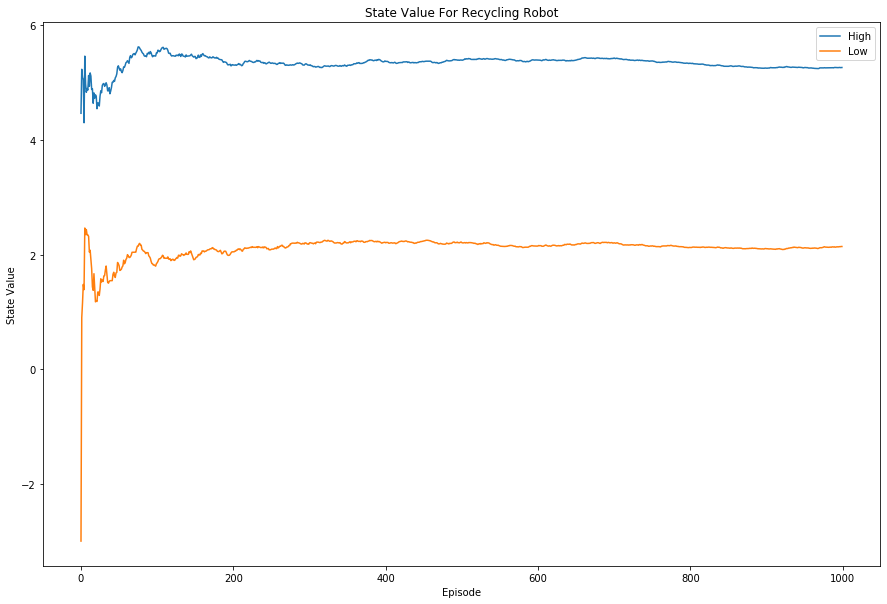

In [327]:
plt.figure(figsize=(15,10))
plt.plot(v_s['high'], label ='High')
plt.plot(v_s['low'],label = 'Low')
plt.legend()
plt.title('State Value For Recycling Robot')
plt.xlabel('Episode')
plt.ylabel('State Value')
plt.show()

In [328]:
print(f"V(high):{v_s['high'][-1]:3.2f},   V(low):{v_s['low'][-1]:3.2f}")

V(high):5.26,   V(low):2.14


In [329]:
q_a  = robot.first_visit_action(1000)

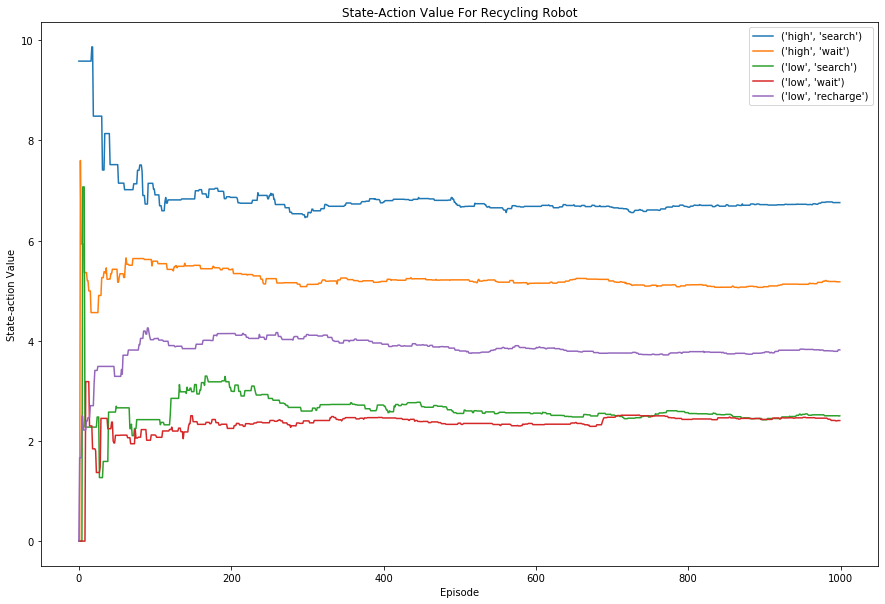

In [330]:
plt.figure(figsize=(15,10))
plt.plot(q_a[('high','search')], label =('high','search'))
plt.plot(q_a[('high','wait')], label =('high','wait'))
plt.plot(q_a[('low','search')], label =('low','search'))
plt.plot(q_a[('low','wait')], label =('low','wait'))
plt.plot(q_a[('low','recharge')], label =('low','recharge'))
plt.legend()
plt.title('State-Action Value For Recycling Robot')
plt.xlabel('Episode')
plt.ylabel('State-action Value')
plt.show()

In [333]:
{k:v[-1] for k,v in q_a.items()}

{('high', 'search'): 6.759336405529953,
 ('high', 'wait'): 5.177583333333335,
 ('low', 'search'): 2.502268041237113,
 ('low', 'wait'): 2.4067282051282053,
 ('low', 'recharge'): 3.818613861386137}

In [267]:
v_s , update_time = robot.td_state(4000,0.05)

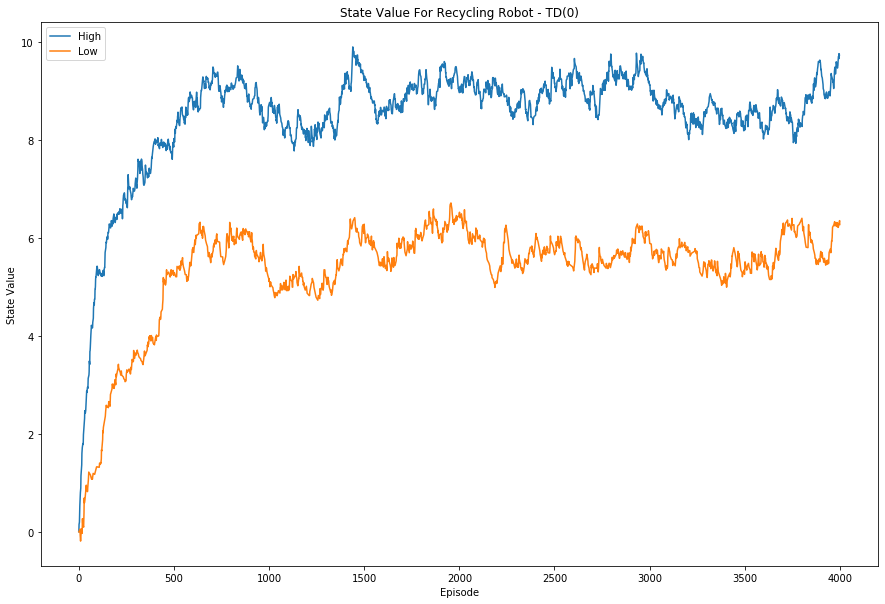

In [276]:
plt.figure(figsize=(15,10))
plt.plot(update_time['high'],v_s['high'], label ='High')
plt.plot(update_time['low'],v_s['low'],label = 'Low')
plt.legend()
plt.title('State Value For Recycling Robot - TD(0)')
plt.xlabel('Episode')
plt.ylabel('State Value')
plt.show()

In [296]:
final_Q,Q_history,Q_update_time= robot.sarsa(5000,0.05,0.1)

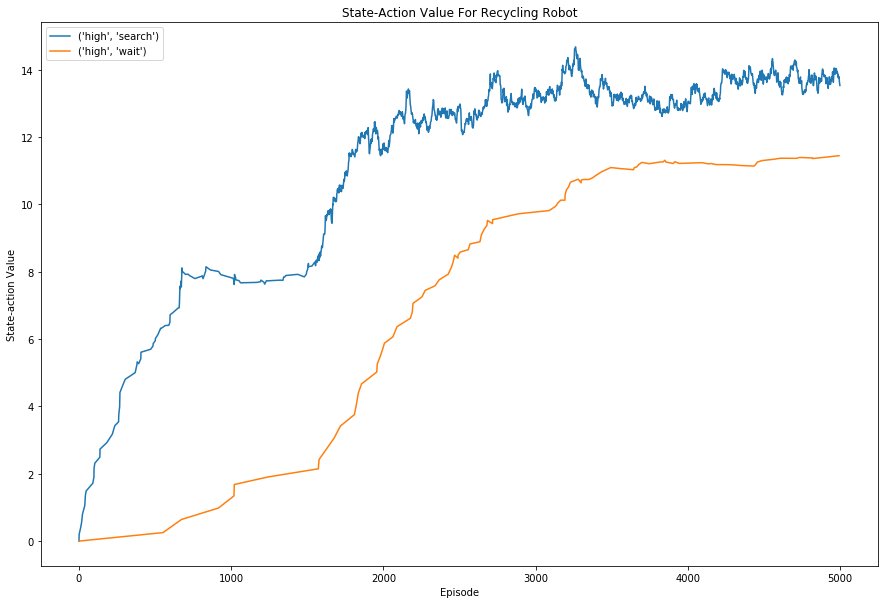

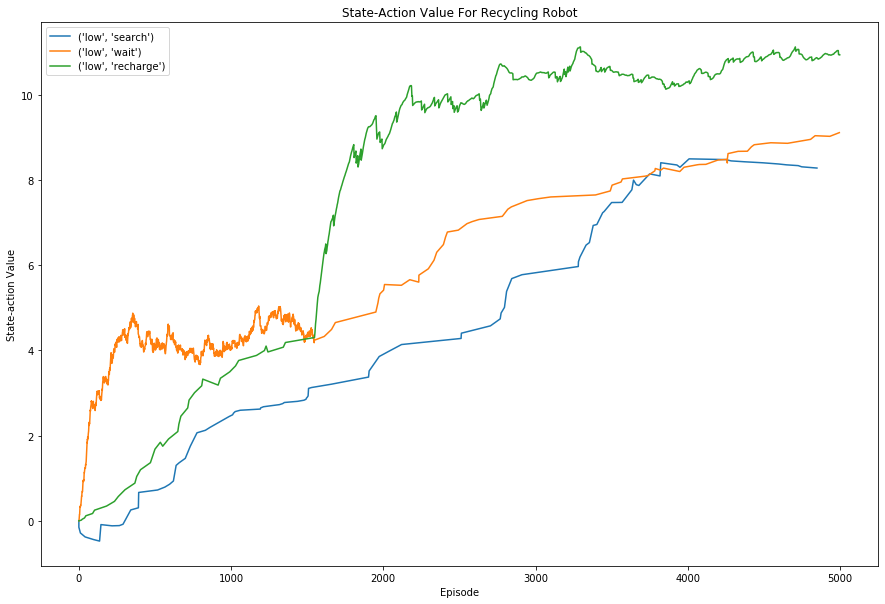

In [298]:
plt.figure(figsize=(15,10))
plt.plot(Q_update_time[('high','search')],Q_history[('high','search')], label =('high','search'))
plt.plot(Q_update_time[('high','wait')] , Q_history[('high','wait')], label =('high','wait'))
plt.legend()
plt.title('State-Action Value For Recycling Robot')
plt.xlabel('Episode')
plt.ylabel('State-action Value')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(Q_update_time[('low','search')], Q_history[('low','search')], label =('low','search'))
plt.plot(Q_update_time[('low','wait')], Q_history[('low','wait')], label =('low','wait'))
plt.plot(Q_update_time[('low','recharge')], Q_history[('low','recharge')], label =('low','recharge'))
plt.legend()
plt.title('State-Action Value For Recycling Robot')
plt.xlabel('Episode')
plt.ylabel('State-action Value')
plt.show()

In [278]:
q_a

{('high', 'search'): [0,
  0,
  9.392,
  9.392,
  6.852,
  8.634666666666666,
  8.634666666666666,
  9.232,
  9.232,
  9.232,
  9.4352,
  9.4352,
  8.598666666666666,
  8.598666666666666,
  8.598666666666666,
  8.598666666666666,
  8.385142857142856,
  7.77,
  7.77,
  7.77,
  7.77,
  7.77,
  7.77,
  7.77,
  7.77,
  7.77,
  7.928888888888888,
  7.928888888888888,
  7.6008,
  7.6008,
  7.6008,
  7.330181818181817,
  7.368666666666666,
  7.368666666666666,
  7.072615384615384,
  7.072615384615384,
  7.2297142857142855,
  7.2297142857142855,
  7.2297142857142855,
  7.2297142857142855,
  7.2297142857142855,
  7.2297142857142855,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.864533333333332,
  6.621999999999999,
  6.621999999999999,
  6.621999999999999,
  6.5496470588235285,
  6.507999999999999,
  6.507999999999999,
  6.413052631578946,
  6.413052631578946,
  6.413052